<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/telur_ayam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7fbf0f307640>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.telur_ayam_ras_segar.values
date = dataset.index

## Train test val split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


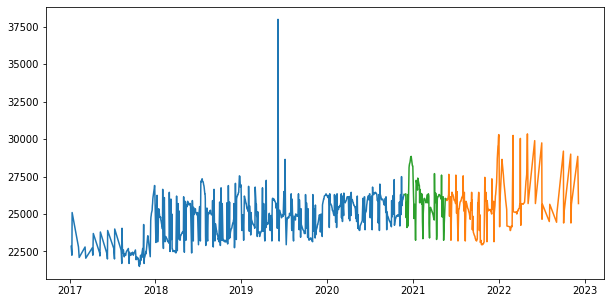

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [9]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [10]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_telur_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [ ]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [ ]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 18s 65ms/step - loss: 0.0529 - mae: 0.2250 - mape: 92.8811 - val_loss: 0.1929 - val_mae: 0.4052 - val_mape: 1047957.0000
Epoch 2/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0356 - mae: 0.1830 - mape: 74.9445 - val_loss: 0.1637 - val_mae: 0.3724 - val_mape: 2095538.1250
Epoch 3/30
44/44 [==============================] - 1s 18ms/step - loss: 0.0246 - mae: 0.1504 - mape: 60.8893 - val_loss: 0.1432 - val_mae: 0.3487 - val_mape: 2883226.7500
Epoch 4/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0174 - mae: 0.1237 - mape: 49.3074 - val_loss: 0.1275 - val_mae: 0.3296 - val_mape: 3544361.2500
Epoch 5/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0124 - mae: 0.1019 - mape: 39.9485 - val_loss: 0.1155 - val_mae: 0.3139 - val_mape: 4087886.7500
Epoch 6/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0091 - mae: 0.0844 - mape: 32.5587 - val_loss: 0.1061 - val_mae:

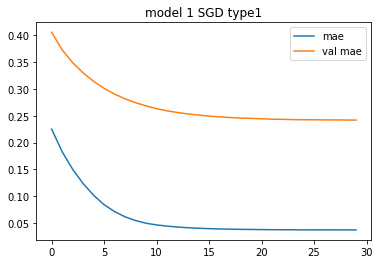

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
1119.3328 4.319655 1563.7104911076092


,date,actual,prediction
0,2021-05-20,26000,25473.392578
1,2021-05-21,26000,25474.617188
2,2021-05-24,25900,25479.732422
3,2021-05-25,25950,25479.093750
4,2021-05-27,26000,25483.972656
...,...,...,...
229,2022-11-02,24400,25493.548828
230,2022-11-03,25000,25493.556641
231,2022-11-04,25650,25493.152344
232,2022-12-01,28850,25491.867188


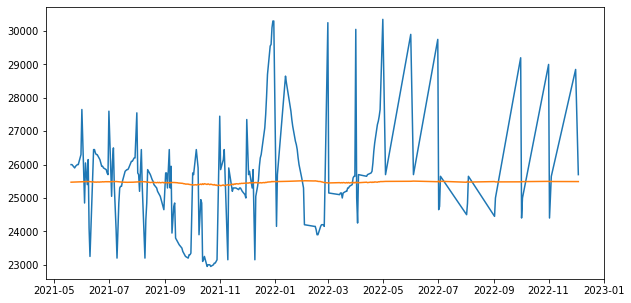

In [ ]:
prediction = forecast_predict(model, test_telur_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_telur = pd.DataFrame()
data_new_telur['date'] = y_test
data_new_telur['actual'] = x_test
data_new_telur['prediction'] = data_result
data_new_telur.to_csv('telur_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_telur.date, data_new_telur.actual)
plt.plot(data_new_telur.date, data_new_telur.prediction)
data_new_telur

#### type2

In [ ]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0055 - mae: 0.0566 - mape: 36.7439 - val_loss: 0.0754 - val_mae: 0.2507 - val_mape: 6258607.0000
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0053 - mae: 0.0556 - mape: 35.3495 - val_loss: 0.0753 - val_mae: 0.2507 - val_mape: 6261819.0000
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0054 - mae: 0.0560 - mape: 35.3566 - val_loss: 0.0753 - val_mae: 0.2507 - val_mape: 6259850.0000
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0054 - mae: 0.0557 - mape: 35.4186 - val_loss: 0.0751 - val_mae: 0.2503 - val_mape: 6281540.5000
Epoch 5/30
718/718 [==============================] - 7s 9ms/step - loss: 0.0054 - mae: 0.0560 - mape: 35.5787 - val_loss: 0.0753 - val_mae: 0.2506 - val_mape: 6269976.5000
Epoch 6/30
718/718 [==============================] - 10s 14ms/step - loss: 0.0053 - mae: 0.0557 - mape: 35.3152 - val_loss: 0.0747 - v

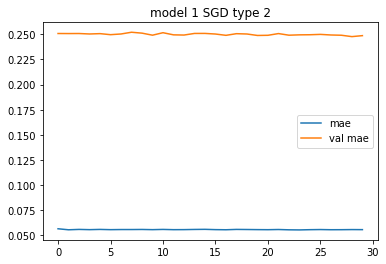

In [ ]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
1139.5609 4.3620653 1587.639363961476


,date,actual,prediction
0,2021-05-20,26000,25473.392578
1,2021-05-21,26000,25474.617188
2,2021-05-24,25900,25479.732422
3,2021-05-25,25950,25479.093750
4,2021-05-27,26000,25483.972656
...,...,...,...
229,2022-11-02,24400,25493.548828
230,2022-11-03,25000,25493.556641
231,2022-11-04,25650,25493.152344
232,2022-12-01,28850,25491.867188


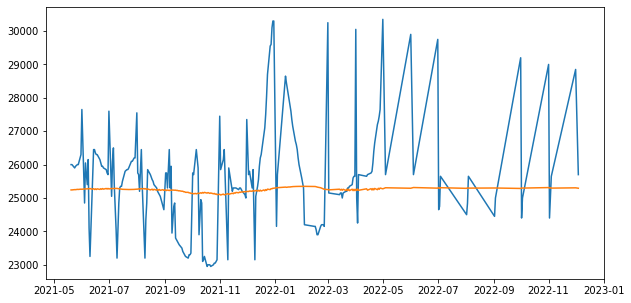

In [ ]:
win_size1 = 60
test_telur_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_telur_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_telur_1 = pd.DataFrame()
data_new_telur_1['actual'] = x_test
data_new_telur_1['prediction'] = data_result_1
data_new_telur_1.to_csv('telur_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_telur_1.actual)
plt.plot(y_test, data_new_telur_1.prediction)
data_new_telur

#### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0046 - mae: 0.0485 - mape: 25.8485 - val_loss: 0.0745 - val_mae: 0.2491 - val_mape: 6362040.0000
Epoch 2/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0045 - mae: 0.0483 - mape: 25.6075 - val_loss: 0.0750 - val_mae: 0.2501 - val_mape: 6322427.5000
Epoch 3/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0045 - mae: 0.0482 - mape: 25.1985 - val_loss: 0.0756 - val_mae: 0.2512 - val_mape: 6284379.5000
Epoch 4/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0045 - mae: 0.0481 - mape: 25.1303 - val_loss: 0.0759 - val_mae: 0.2517 - val_mape: 6266167.5000
Epoch 5/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0045 - mae: 0.0481 - mape: 25.2538 - val_loss: 0.0757 - val_mae: 0.2513 - val_mape: 6282043.5000
Epoch 6/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0045 - mae: 0.0481 - mape: 25.1623 - val_loss: 0.0760 - val_mae: 

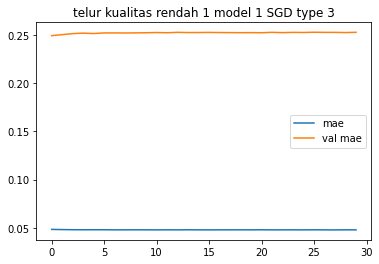

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('telur kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
1160.5687 4.4308143 1606.1098187857517


,actual,prediction
0,26000,25157.521484
1,26000,25158.044922
2,25900,25167.609375
3,25950,25165.958984
4,26000,25175.791016
...,...,...
229,24400,25219.044922
230,25000,25230.320312
231,25650,25215.751953
232,28850,25227.544922


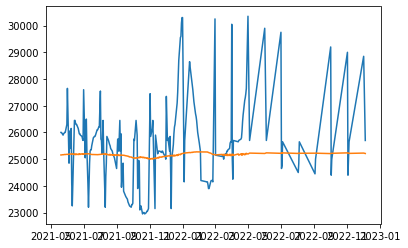

In [ ]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_telur_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_telur_2 = pd.DataFrame()
# data_new_telur1['date'] = date_test
data_new_telur_2['actual'] = x_test
data_new_telur_2['prediction'] = data_result_2
data_new_telur_2.to_csv('telur_model1_sgd_type3')

plt.plot(y_test, data_new_telur_2.actual)
plt.plot(y_test, data_new_telur_2.prediction)
data_new_telur_2

### Adam

In [ ]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 4s 38ms/step - loss: 0.0368 - mae: 0.1850 - mape: 75.6122 - val_loss: 0.1260 - val_mae: 0.3276 - val_mape: 3829953.2500
Epoch 2/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0115 - mae: 0.0940 - mape: 36.8888 - val_loss: 0.0571 - val_mae: 0.2176 - val_mape: 7875597.0000
Epoch 3/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0023 - mae: 0.0399 - mape: 18.2581 - val_loss: 0.0473 - val_mae: 0.1977 - val_mape: 8822390.0000
Epoch 4/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0021 - mae: 0.0390 - mape: 17.5669 - val_loss: 0.0472 - val_mae: 0.1975 - val_mape: 8832419.0000
Epoch 5/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0021 - mae: 0.0383 - mape: 17.6512 - val_loss: 0.0493 - val_mae: 0.2023 - val_mape: 8605578.0000
Epoch 6/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0022 - mae: 0.0391 - mape: 17.7288 - val_loss: 0.0483 - val_mae: 

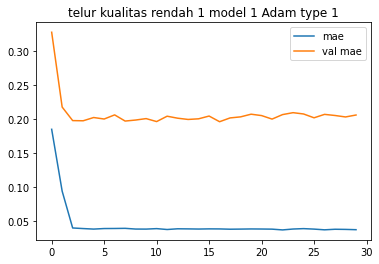

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('telur kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
1109.8596 4.2882323 1531.9281967507484


,actual,prediction
0,26000,25420.199219
1,26000,25460.783203
2,25900,25442.939453
3,25950,25475.738281
4,26000,25461.275391
...,...,...
229,24400,25724.111328
230,25000,25782.042969
231,25650,25722.646484
232,28850,25777.082031


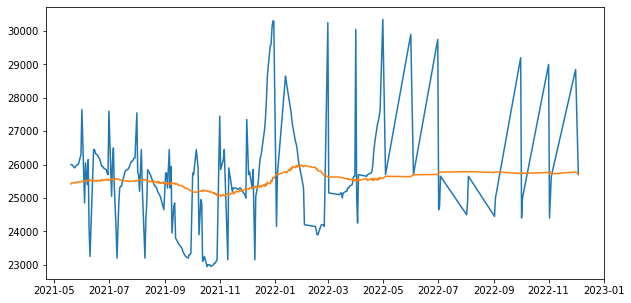

In [ ]:
prediction_a = forecast_predict(model_a, test_telur_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_telur_a = pd.DataFrame()
# data_new_telur1['date'] = date_test
data_new_telur_a['actual'] = x_test
data_new_telur_a['prediction'] = data_result_a
data_new_telur_a.to_csv('telur_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_telur_a.actual)
plt.plot(y_test, data_new_telur_a.prediction)
data_new_telur_a

#### Type 2

In [ ]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0051 - mae: 0.0542 - mape: 33.2309 - val_loss: 0.0502 - val_mae: 0.2033 - val_mape: 8644937.0000
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0050 - mae: 0.0536 - mape: 32.8296 - val_loss: 0.0495 - val_mae: 0.2014 - val_mape: 8858329.0000
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0049 - mae: 0.0532 - mape: 32.4365 - val_loss: 0.0480 - val_mae: 0.1976 - val_mape: 9156835.0000
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0049 - mae: 0.0515 - mape: 31.8237 - val_loss: 0.0500 - val_mae: 0.2015 - val_mape: 9020269.0000
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0048 - mae: 0.0520 - mape: 31.7601 - val_loss: 0.0492 - val_mae: 0.1991 - val_mape: 9265255.0000
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0047 - mae: 0.0520 - mape: 31.6660 - val_loss: 0.0544 - val

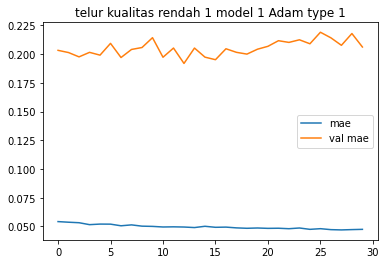

In [ ]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('telur kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
1096.1615 4.1975245 1476.2791910746423


,actual,prediction
0,26000,25461.683594
1,26000,25417.634766
2,25900,25506.230469
3,25950,25454.845703
4,26000,25532.150391
...,...,...
229,24400,25206.314453
230,25000,25333.037109
231,25650,25136.496094
232,28850,25266.703125


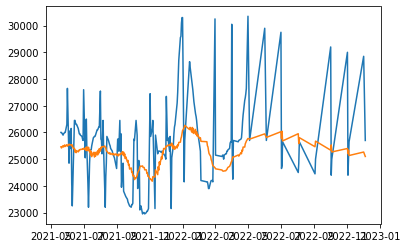

In [ ]:
prediction_a1 = forecast_predict(model_a, test_telur_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_telur_a1 = pd.DataFrame()
data_new_telur_a1['actual'] = x_test
data_new_telur_a1['prediction'] = data_result_a1
data_new_telur_a1.to_csv('telur_model1_adam_type2.csv')

plt.plot(y_test, data_new_telur_a1.actual)
plt.plot(y_test, data_new_telur_a1.prediction)
data_new_telur_a1

#### Type 3

In [ ]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0038 - mae: 0.0404 - mape: 21.3078 - val_loss: 0.0617 - val_mae: 0.2202 - val_mape: 8651435.0000
Epoch 2/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0037 - mae: 0.0401 - mape: 20.4533 - val_loss: 0.0593 - val_mae: 0.2146 - val_mape: 8962379.0000
Epoch 3/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0037 - mae: 0.0398 - mape: 20.0459 - val_loss: 0.0577 - val_mae: 0.2114 - val_mape: 9031788.0000
Epoch 4/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0037 - mae: 0.0400 - mape: 20.3210 - val_loss: 0.0578 - val_mae: 0.2116 - val_mape: 9008142.0000
Epoch 5/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0037 - mae: 0.0398 - mape: 20.5118 - val_loss: 0.0594 - val_mae: 0.2149 - val_mape: 8881954.0000
Epoch 6/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0037 - mae: 0.0400 - mape: 20.3481 - val_loss: 0.0588 - val_mae: 

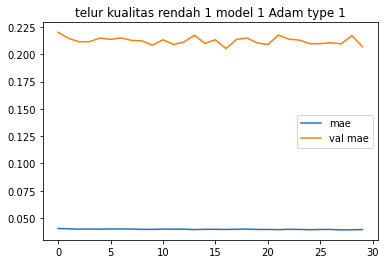

In [ ]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('telur kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
1078.3674 4.1485023 1441.473204745756


,actual,prediction
0,26000,25694.027344
1,26000,25770.826172
2,25900,25835.435547
3,25950,25895.001953
4,26000,25948.326172
...,...,...
229,24400,25407.912109
230,25000,25729.474609
231,25650,25255.291016
232,28850,25580.140625


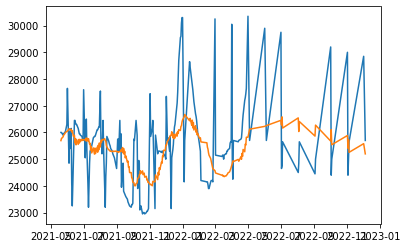

In [ ]:
prediction_a2 = forecast_predict(model_a, test_telur_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_telur_a2 = pd.DataFrame()
# data_new_telur1['date'] = date_test
data_new_telur_a2['actual'] = x_test
data_new_telur_a2['prediction'] = data_result_a2
data_new_telur_a2.to_csv('telur_model1_adam_type3.csv')

plt.plot(y_test, data_new_telur_a2.actual)
plt.plot(y_test, data_new_telur_a2.prediction)
data_new_telur_a2

## model 1

### Adam

In [11]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          96        
                                                                 
 lstm (LSTM)                 (None, None, 128)         74240     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-trai

#### Type 1

In [ ]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 11s 90ms/step - loss: 0.0292 - mae: 0.1535 - mape: 62.6929 - val_loss: 0.0372 - val_mae: 0.1673 - val_mape: 10341344.0000
Epoch 2/15
44/44 [==============================] - 1s 31ms/step - loss: 0.0024 - mae: 0.0388 - mape: 18.0391 - val_loss: 0.0421 - val_mae: 0.1840 - val_mape: 9669243.0000
Epoch 3/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0022 - mae: 0.0391 - mape: 17.7335 - val_loss: 0.0417 - val_mae: 0.1826 - val_mape: 9747893.0000
Epoch 4/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0022 - mae: 0.0388 - mape: 17.6724 - val_loss: 0.0434 - val_mae: 0.1875 - val_mape: 9524108.0000
Epoch 5/15
44/44 [==============================] - 1s 32ms/step - loss: 0.0022 - mae: 0.0392 - mape: 17.5392 - val_loss: 0.0396 - val_mae: 0.1757 - val_mape: 10089641.0000
Epoch 6/15
44/44 [==============================] - 2s 34ms/step - loss: 0.0023 - mae: 0.0395 - mape: 18.0260 - val_loss: 0.0419 - val_ma

17/17 [==============================] - 0s 6ms/step - loss: 0.0727 - mae: 0.1912 - mape: 48.9811


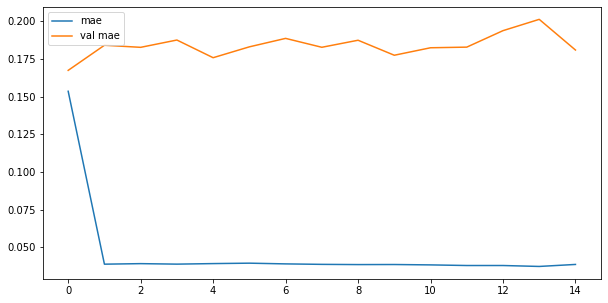

In [ ]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1 = forecast_predict(model1, test_telur_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_telur1 = pd.DataFrame()
data_new_telur1['actual'] = x_test
data_new_telur1['prediction'] = data_result1
data_new_telur1.to_csv('telur_model2_adam_type1.csv')

data_new_telur1

131/131 [==============================] - 2s 7ms/step
1144.9532 4.467071 1540.4767930741443


,actual,prediction
0,26000,25635.630859
1,26000,25644.826172
2,25900,25677.615234
3,25950,25682.712891
4,26000,25716.136719
...,...,...
229,24400,26123.052734
230,25000,26237.351562
231,25650,26113.376953
232,28850,26218.919922


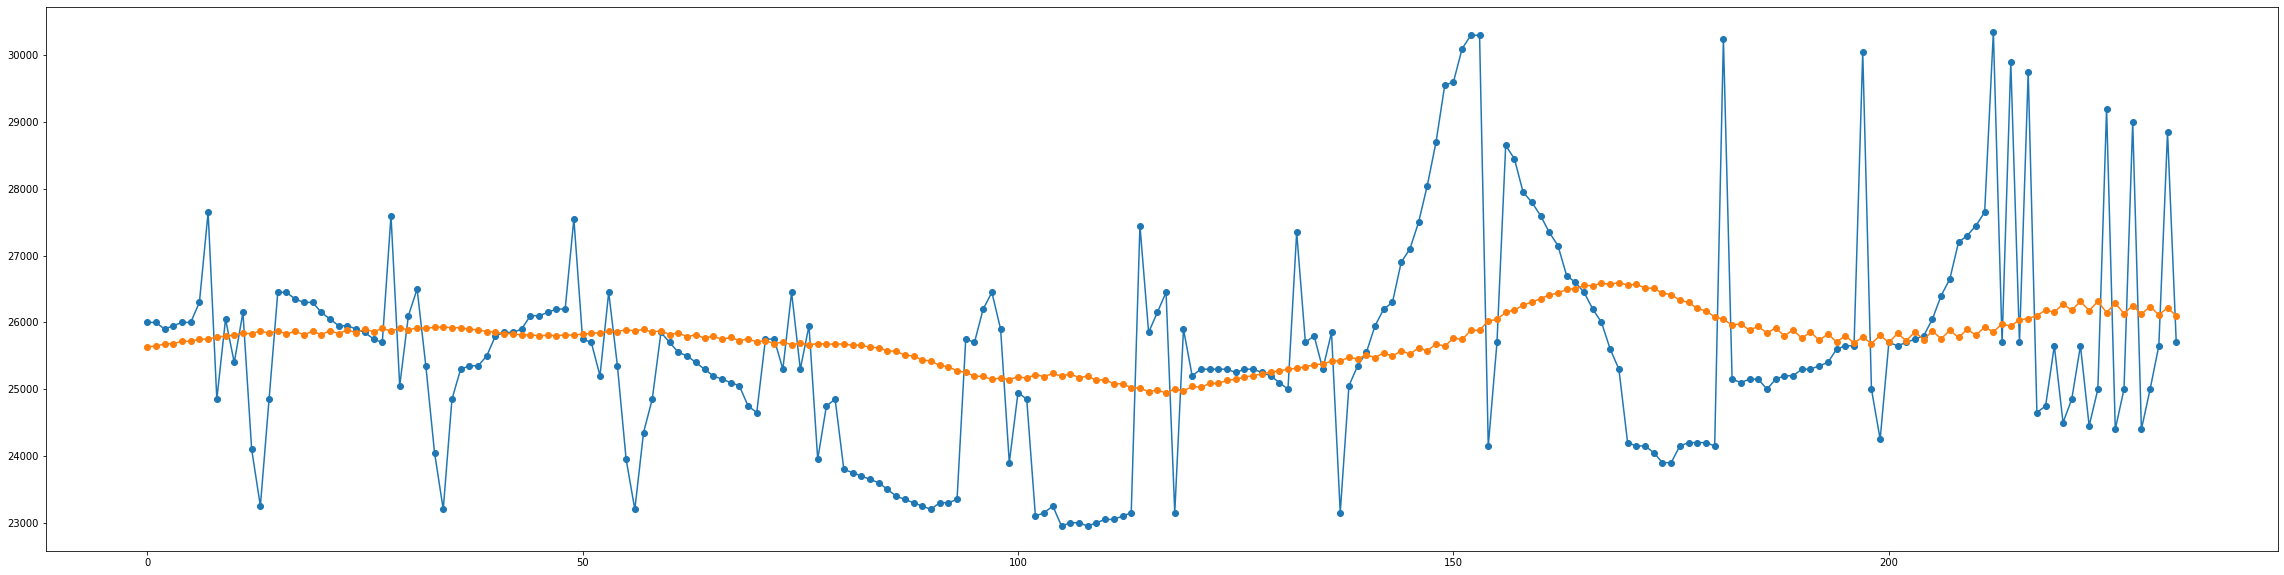

In [ ]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_telur1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_telur1['prediction'], '-o')

#### Type 2

In [12]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 54s 62ms/step - loss: 0.0066 - mae: 0.0603 - mape: 34.6596 - val_loss: 0.0535 - val_mae: 0.2106 - val_mape: 8257093.0000
Epoch 2/15
718/718 [==============================] - 41s 58ms/step - loss: 0.0052 - mae: 0.0553 - mape: 33.1568 - val_loss: 0.0499 - val_mae: 0.2026 - val_mape: 8802172.0000
Epoch 3/15
718/718 [==============================] - 34s 48ms/step - loss: 0.0051 - mae: 0.0541 - mape: 32.6347 - val_loss: 0.0558 - val_mae: 0.2134 - val_mape: 8361776.5000
Epoch 4/15
718/718 [==============================] - 35s 49ms/step - loss: 0.0049 - mae: 0.0529 - mape: 31.7302 - val_loss: 0.0555 - val_mae: 0.2114 - val_mape: 8657497.0000
Epoch 5/15
718/718 [==============================] - 34s 47ms/step - loss: 0.0050 - mae: 0.0538 - mape: 32.7470 - val_loss: 0.0509 - val_mae: 0.1997 - val_mape: 9525412.0000
Epoch 6/15
718/718 [==============================] - 34s 47ms/step - loss: 0.0049 - mae: 0.0519 - mape: 31.7590 - val_loss: 

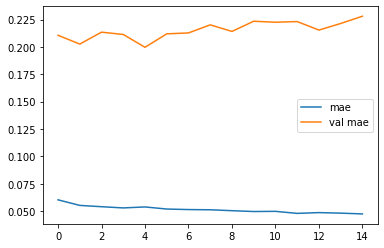

In [13]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 3s 9ms/step
1096.7087 4.188707 1486.929974813878


,actual,prediction
0,26000,25460.199219
1,26000,25499.892578
2,25900,25523.019531
3,25950,25537.232422
4,26000,25558.193359
...,...,...
229,24400,25178.621094
230,25000,25221.527344
231,25650,25131.138672
232,28850,25147.855469


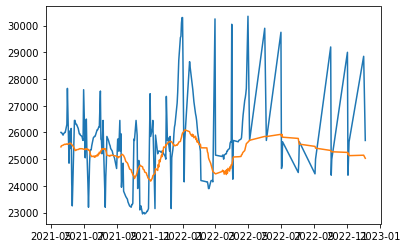

In [14]:
prediction1_1 = forecast_predict(model1, test_telur_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1_1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_telur1_1 = pd.DataFrame()
data_new_telur1_1['actual'] = x_test
data_new_telur1_1['prediction'] = data_result1_1
data_new_telur1_1.to_csv('telur_model2_adam_type2.csv')

plt.plot(y_test, data_new_telur1_1.actual)
plt.plot(y_test, data_new_telur1_1.prediction)
data_new_telur1_1

#### Type 3

In [ ]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 22s 258ms/step - loss: 0.0040 - mae: 0.0434 - mape: 22.0614 - val_loss: 0.0444 - val_mae: 0.1858 - val_mape: 10361943.0000
Epoch 2/15
84/84 [==============================] - 17s 196ms/step - loss: 0.0040 - mae: 0.0437 - mape: 22.1649 - val_loss: 0.0439 - val_mae: 0.1840 - val_mape: 10529640.0000
Epoch 3/15
84/84 [==============================] - 16s 192ms/step - loss: 0.0041 - mae: 0.0451 - mape: 23.0165 - val_loss: 0.0420 - val_mae: 0.1783 - val_mape: 10898424.0000
Epoch 4/15
84/84 [==============================] - 17s 204ms/step - loss: 0.0042 - mae: 0.0439 - mape: 22.2884 - val_loss: 0.0473 - val_mae: 0.1921 - val_mape: 10201942.0000
Epoch 5/15
84/84 [==============================] - 16s 191ms/step - loss: 0.0039 - mae: 0.0427 - mape: 21.8215 - val_loss: 0.0464 - val_mae: 0.1889 - val_mape: 10460609.0000
Epoch 6/15
84/84 [==============================] - 16s 191ms/step - loss: 0.0040 - mae: 0.0431 - mape: 22.0535 - val_loss: 0

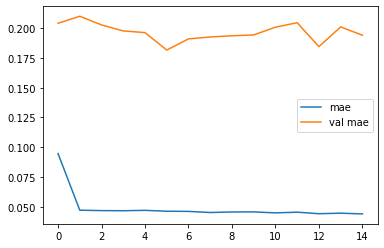

In [ ]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 3s 13ms/step
1107.1539 4.3029714 1465.7124547468375


,actual,prediction
0,26000,25760.039062
1,26000,25869.814453
2,25900,25862.324219
3,25950,25975.576172
4,26000,25947.337891
...,...,...
229,24400,26310.914062
230,25000,26045.197266
231,25650,26067.390625
232,28850,25906.250000


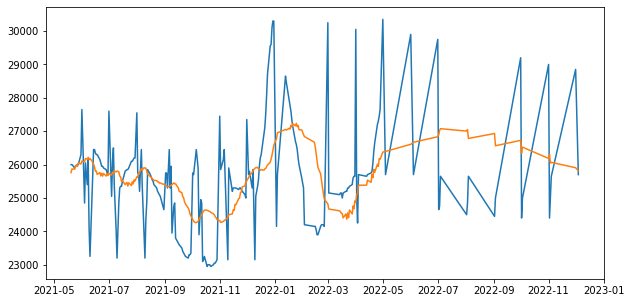

In [ ]:
prediction1_2 = forecast_predict(model1, test_telur_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1_2.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_telur1_2 = pd.DataFrame()
data_new_telur1_2['actual'] = x_test
data_new_telur1_2['prediction'] = data_result1_2
data_new_telur1_2.to_csv('telur_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_telur1_2.actual)
plt.plot(y_test, data_new_telur1_2.prediction)

data_new_telur1_2

### SGD

In [ ]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_10 (LSTM)              (None, None, 128)         74240     
                                                                 
 lstm_11 (LSTM)              (None, 32)                20608     
                                                                 
 dense_13 (Dense)            (None, 64)                2112      
                                                                 
 dense_14 (Dense)            (None, 128)               8320      
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [ ]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 9s 80ms/step - loss: 0.0479 - mae: 0.2141 - mape: 88.4822 - val_loss: 0.1737 - val_mae: 0.3837 - val_mape: 1713131.0000
Epoch 2/15
44/44 [==============================] - 2s 38ms/step - loss: 0.0272 - mae: 0.1579 - mape: 63.9809 - val_loss: 0.1367 - val_mae: 0.3410 - val_mape: 3157119.7500
Epoch 3/15
44/44 [==============================] - 2s 34ms/step - loss: 0.0148 - mae: 0.1128 - mape: 44.6562 - val_loss: 0.1132 - val_mae: 0.3109 - val_mape: 4202124.0000
Epoch 4/15
44/44 [==============================] - 2s 34ms/step - loss: 0.0085 - mae: 0.0813 - mape: 31.3336 - val_loss: 0.0983 - val_mae: 0.2893 - val_mape: 4946317.5000
Epoch 5/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0053 - mae: 0.0621 - mape: 23.8870 - val_loss: 0.0884 - val_mae: 0.2736 - val_mape: 5486461.0000
Epoch 6/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0036 - mae: 0.0511 - mape: 20.1468 - val_loss: 0.0817 - val_mae: 

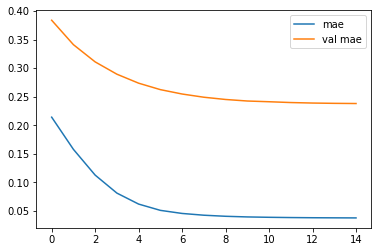

In [ ]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
1120.5732 4.3238235 1565.0702859616242


,actual,prediction
0,26000,25451.863281
1,26000,25452.091797
2,25900,25457.126953
3,25950,25456.775391
4,26000,25461.494141
...,...,...
229,24400,25489.101562
230,25000,25505.982422
231,25650,25486.427734
232,28850,25508.781250


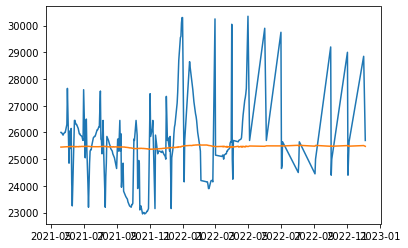

In [ ]:
prediction1_a = forecast_predict(model1_a, test_telur_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_telur1_a = pd.DataFrame()
data_new_telur1_a['actual'] = x_test
data_new_telur1_a['prediction'] = data_result1_a
data_new_telur1_a.to_csv('telur_model2_sgd_type1.csv')


plt.plot(y_test, data_new_telur1_a.actual)
plt.plot(y_test, data_new_telur1_a.prediction)

data_new_telur1_a

#### Type 2


In [ ]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0055 - mae: 0.0564 - mape: 36.1379 - val_loss: 0.0723 - val_mae: 0.2450 - val_mape: 6479191.5000
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0054 - mae: 0.0558 - mape: 35.3152 - val_loss: 0.0732 - val_mae: 0.2468 - val_mape: 6419190.5000
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0053 - mae: 0.0558 - mape: 35.2644 - val_loss: 0.0724 - val_mae: 0.2451 - val_mape: 6479355.5000
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0053 - mae: 0.0559 - mape: 35.0886 - val_loss: 0.0711 - val_mae: 0.2425 - val_mape: 6568552.0000
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0054 - mae: 0.0559 - mape: 35.2923 - val_loss: 0.0717 - val_mae: 0.2437 - val_mape: 6527494.5000
Epoch 6/15
718/718 [==============================] - 6s 8ms/step - loss: 0.0054 - mae: 0.0562 - mape: 35.5708 - val_loss: 0.0733 - val

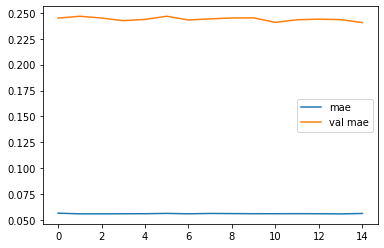

In [ ]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
1123.1245 4.316104 1573.2433854938022


,actual,prediction
0,26000,25339.289062
1,26000,25344.158203
2,25900,25346.414062
3,25950,25350.113281
4,26000,25352.748047
...,...,...
229,24400,25394.203125
230,25000,25420.351562
231,25650,25392.033203
232,28850,25422.130859


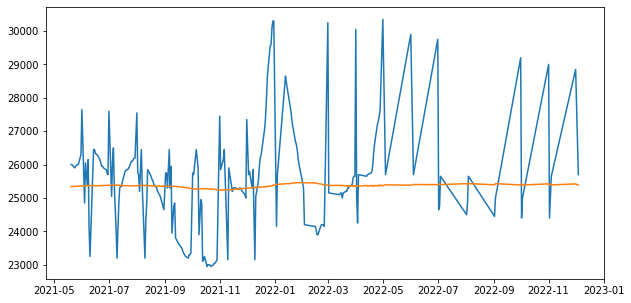

In [ ]:
prediction1_a1 = forecast_predict(model1_a, test_telur_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_telur1_a1 = pd.DataFrame()
data_new_telur1_a1['actual'] = x_test
data_new_telur1_a1['prediction'] = data_result1_a1
data_new_telur1_a1.to_csv('telur_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_telur1_a1.actual)
plt.plot(y_test, data_new_telur1_a1.prediction)
data_new_telur1_a1

#### Type 3

In [ ]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0046 - mae: 0.0492 - mape: 26.6253 - val_loss: 0.0725 - val_mae: 0.2453 - val_mape: 6483746.0000
Epoch 2/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0046 - mae: 0.0487 - mape: 25.9182 - val_loss: 0.0733 - val_mae: 0.2469 - val_mape: 6426441.5000
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0046 - mae: 0.0484 - mape: 25.3594 - val_loss: 0.0743 - val_mae: 0.2488 - val_mape: 6362543.0000
Epoch 4/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0046 - mae: 0.0484 - mape: 25.3474 - val_loss: 0.0743 - val_mae: 0.2488 - val_mape: 6362936.0000
Epoch 5/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0046 - mae: 0.0484 - mape: 25.1524 - val_loss: 0.0745 - val_mae: 0.2491 - val_mape: 6350463.5000
Epoch 6/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0046 - mae: 0.0484 - mape: 25.2029 - val_loss: 0.0743 - val_mae: 

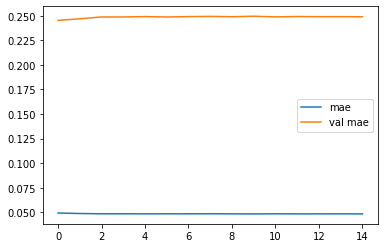

In [ ]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
1163.5468 4.4436703 1610.0925439241062


,actual,prediction
0,26000,25147.587891
1,26000,25152.333984
2,25900,25154.849609
3,25950,25158.355469
4,26000,25161.560547
...,...,...
229,24400,25213.351562
230,25000,25242.128906
231,25650,25210.185547
232,28850,25243.201172


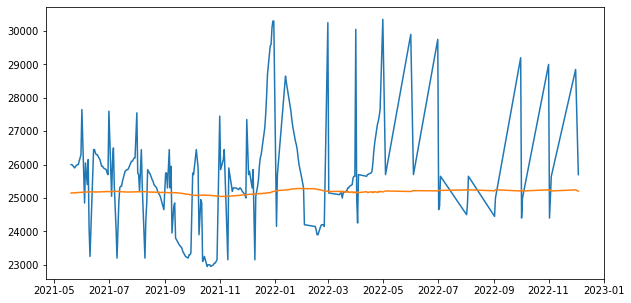

In [ ]:
prediction1_a2 = forecast_predict(model1_a, test_telur_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_telur1_a2 = pd.DataFrame()
data_new_telur1_a2['actual'] = x_test
data_new_telur1_a2['prediction'] = data_result1_a2
data_new_telur1_a2.to_csv('telur_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_telur1_a2.actual)
plt.plot(y_test, data_new_telur1_a2.prediction)

data_new_telur1_a2

## model 2

### SGD

In [ ]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_12 (LSTM)              (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_13 (LSTM)              (None, 64)                20224     
                                                                 
 dense_16 (Dense)            (None, 24)                1560      
                                                      

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [ ]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 34ms/step - loss: 0.0593 - mae: 0.2390 - mape: 98.9416 - val_loss: 0.2112 - val_mae: 0.4251 - val_mape: 458049.6875
Epoch 2/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0426 - mae: 0.2012 - mape: 82.7684 - val_loss: 0.1815 - val_mae: 0.3923 - val_mape: 1447190.5000
Epoch 3/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0306 - mae: 0.1688 - mape: 68.7282 - val_loss: 0.1589 - val_mae: 0.3669 - val_mape: 2266683.0000
Epoch 4/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0224 - mae: 0.1424 - mape: 57.3188 - val_loss: 0.1419 - val_mae: 0.3472 - val_mape: 2934826.5000
Epoch 5/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0167 - mae: 0.1210 - mape: 48.1432 - val_loss: 0.1287 - val_mae: 0.3312 - val_mape: 3488611.5000
Epoch 6/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0127 - mae: 0.1029 - mape: 40.3366 - val_loss: 0.1183 - val_mae: 0

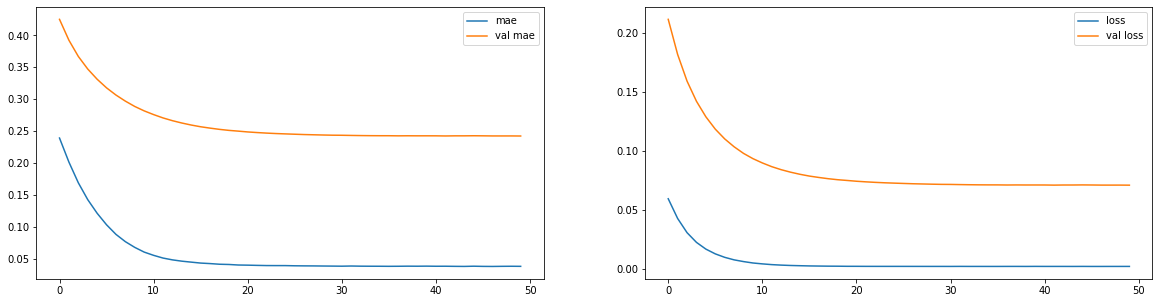

In [ ]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 1s 6ms/step
1125.0488 4.3504057 1569.9800157963796


,actual,prediction
0,26000,25510.767578
1,26000,25511.392578
2,25900,25510.490234
3,25950,25513.710938
4,26000,25513.253906
...,...,...
229,24400,25532.871094
230,25000,25526.859375
231,25650,25532.525391
232,28850,25527.816406


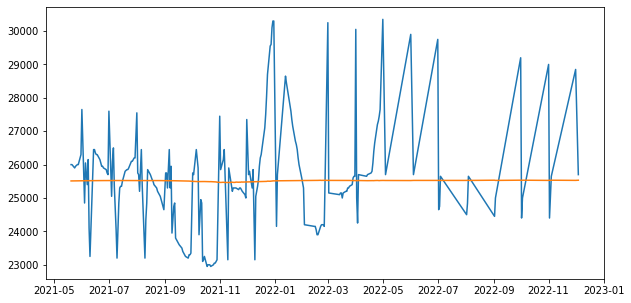

In [ ]:
prediction2 = forecast_predict(model2, test_telur_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_telur2 = pd.DataFrame()
data_new_telur2['actual'] = x_test
data_new_telur2['prediction'] = data_result2
data_new_telur2.to_csv('telur_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_telur2.actual)
plt.plot(y_test, data_new_telur2.prediction)
data_new_telur2

#### Type2

In [ ]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0058 - mae: 0.0576 - mape: 38.1377 - val_loss: 0.0777 - val_mae: 0.2552 - val_mape: 6111411.5000
Epoch 2/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0055 - mae: 0.0567 - mape: 35.9953 - val_loss: 0.0774 - val_mae: 0.2545 - val_mape: 6131813.5000
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0055 - mae: 0.0565 - mape: 35.8488 - val_loss: 0.0774 - val_mae: 0.2546 - val_mape: 6130224.5000
Epoch 4/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0054 - mae: 0.0562 - mape: 35.5193 - val_loss: 0.0766 - val_mae: 0.2532 - val_mape: 6180511.0000
Epoch 5/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0054 - mae: 0.0563 - mape: 35.8281 - val_loss: 0.0768 - val_mae: 0.2535 - val_mape: 6171035.5000
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0054 - mae: 0.0563 - mape: 35.4424 - val_loss: 0.0756 - val

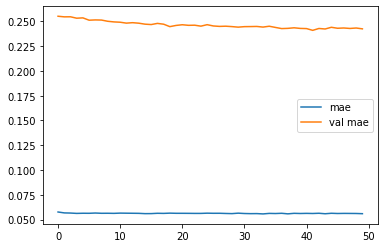

In [ ]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_1 = forecast_predict(model2, test_telur_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_telur2_1 = pd.DataFrame()
data_new_telur2_1['actual'] = x_test
data_new_telur2_1['prediction'] = data_result2_1
data_new_telur2_1.to_csv('telur_model3_sgd_type2.csv')

data_new_telur2

199/199 [==============================] - 1s 3ms/step
1167.7249 4.461842 1609.7045536370952


,actual,prediction
0,26000,25510.767578
1,26000,25511.392578
2,25900,25510.490234
3,25950,25513.710938
4,26000,25513.253906
...,...,...
229,24400,25532.871094
230,25000,25526.859375
231,25650,25532.525391
232,28850,25527.816406


#### Type 3

In [ ]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0045 - mae: 0.0482 - mape: 25.3456 - val_loss: 0.0714 - val_mae: 0.2433 - val_mape: 6525007.5000
Epoch 2/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0046 - mae: 0.0486 - mape: 25.4912 - val_loss: 0.0715 - val_mae: 0.2434 - val_mape: 6520292.5000
Epoch 3/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0045 - mae: 0.0481 - mape: 25.1408 - val_loss: 0.0717 - val_mae: 0.2437 - val_mape: 6509048.0000
Epoch 4/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0045 - mae: 0.0480 - mape: 25.0735 - val_loss: 0.0719 - val_mae: 0.2441 - val_mape: 6495134.0000
Epoch 5/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0046 - mae: 0.0484 - mape: 25.1863 - val_loss: 0.0719 - val_mae: 0.2442 - val_mape: 6492856.0000
Epoch 6/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0046 - mae: 0.0486 - mape: 25.2839 - val_loss: 0.0719 - val_mae: 

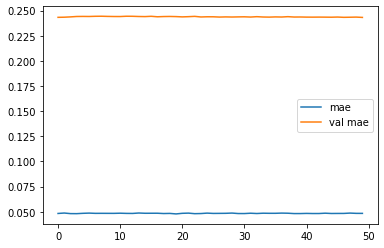

In [ ]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_2 = forecast_predict(model2, test_telur_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_telur2_2 = pd.DataFrame()
data_new_telur2_2['actual'] = x_test
data_new_telur2_2['prediction'] = data_result2_2
data_new_telur2_2.to_csv('telur_model3_sgd-type3.csv')

data_new_telur2_2

181/181 [==============================] - 1s 4ms/step
1162.6072 4.444154 1603.7811571408363


,actual,prediction
0,26000,25154.265625
1,26000,25161.519531
2,25900,25163.458984
3,25950,25163.464844
4,26000,25167.404297
...,...,...
229,24400,25303.294922
230,25000,25321.566406
231,25650,25297.875000
232,28850,25304.937500


### Adam

In [ ]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_16 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_2 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_17 (LSTM)              (None, 80)                33600     
                                                                 
 dense_22 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [ ]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 8s 50ms/step - loss: 0.0540 - mae: 0.2269 - mape: 93.6785 - val_loss: 0.1791 - val_mae: 0.3897 - val_mape: 1493824.2500
Epoch 2/50
44/44 [==============================] - 1s 17ms/step - loss: 0.0228 - mae: 0.1367 - mape: 55.1441 - val_loss: 0.0590 - val_mae: 0.2225 - val_mape: 7214698.5000
Epoch 3/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0024 - mae: 0.0391 - mape: 18.0959 - val_loss: 0.0545 - val_mae: 0.2138 - val_mape: 7604476.5000
Epoch 4/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0022 - mae: 0.0401 - mape: 18.2141 - val_loss: 0.0505 - val_mae: 0.2058 - val_mape: 7975084.0000
Epoch 5/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0024 - mae: 0.0406 - mape: 18.3185 - val_loss: 0.0522 - val_mae: 0.2092 - val_mape: 7822320.5000
Epoch 6/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0023 - mae: 0.0401 - mape: 18.4155 - val_loss: 0.0535 - val_mae: 

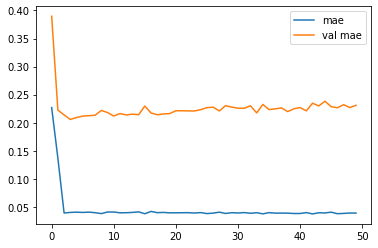

In [ ]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_a = forecast_predict(model2_a, test_telur_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_telur2_a = pd.DataFrame()
data_new_telur2_a['actual'] = x_test
data_new_telur2_a['prediction'] = data_result2_a
data_new_telur2_a.to_csv('telur_model3_adam-type1.csv')

data_new_telur2_a

131/131 [==============================] - 1s 6ms/step
1123.3738 4.330976 1564.9826676356515


,actual,prediction
0,26000,25393.330078
1,26000,25400.375000
2,25900,25392.574219
3,25950,25409.351562
4,26000,25402.693359
...,...,...
229,24400,25617.966797
230,25000,25586.527344
231,25650,25627.037109
232,28850,25629.539062


#### Type 2

In [ ]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0054 - mae: 0.0562 - mape: 33.9122 - val_loss: 0.0602 - val_mae: 0.2229 - val_mape: 7399985.5000
Epoch 2/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0053 - mae: 0.0555 - mape: 33.9315 - val_loss: 0.0631 - val_mae: 0.2275 - val_mape: 7275867.5000
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0051 - mae: 0.0549 - mape: 33.5681 - val_loss: 0.0619 - val_mae: 0.2248 - val_mape: 7458446.5000
Epoch 4/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0050 - mae: 0.0538 - mape: 32.9220 - val_loss: 0.0493 - val_mae: 0.2005 - val_mape: 8733085.0000
Epoch 5/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0050 - mae: 0.0538 - mape: 33.0819 - val_loss: 0.0655 - val_mae: 0.2303 - val_mape: 7592597.0000
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0049 - mae: 0.0527 - mape: 32.1800 - val_loss: 0.0677 - val

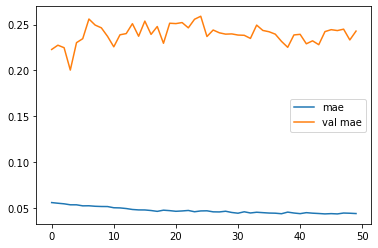

In [ ]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
1140.6389 4.348495 1588.7802711514264


,actual,prediction
0,26000,25815.121094
1,26000,25895.773438
2,25900,25864.933594
3,25950,25843.591797
4,26000,25843.208984
...,...,...
229,24400,24941.324219
230,25000,24969.009766
231,25650,24967.759766
232,28850,24984.517578


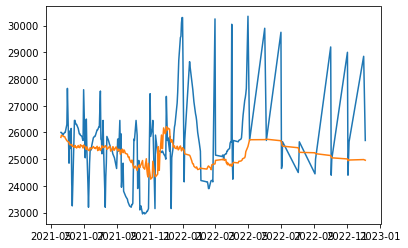

In [ ]:
prediction2_a1 = forecast_predict(model2_a, test_telur_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_telur2_a1 = pd.DataFrame()
data_new_telur2_a1['actual'] = x_test
data_new_telur2_a1['prediction'] = data_result2_a1
data_new_telur2_a1.to_csv('telur_model3_adam-type2.csv')

plt.plot(y_test, data_new_telur2_a1.actual)
plt.plot(y_test, data_new_telur2_a1.prediction)
data_new_telur2_a1

#### Type 3

In [ ]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0035 - mae: 0.0377 - mape: 19.5443 - val_loss: 0.0738 - val_mae: 0.2481 - val_mape: 6445525.0000
Epoch 2/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0034 - mae: 0.0371 - mape: 18.4861 - val_loss: 0.0721 - val_mae: 0.2449 - val_mape: 6470785.5000
Epoch 3/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0034 - mae: 0.0376 - mape: 19.0499 - val_loss: 0.0731 - val_mae: 0.2468 - val_mape: 6423390.5000
Epoch 4/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0035 - mae: 0.0380 - mape: 19.0449 - val_loss: 0.0728 - val_mae: 0.2462 - val_mape: 6462647.0000
Epoch 5/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0034 - mae: 0.0370 - mape: 18.6933 - val_loss: 0.0742 - val_mae: 0.2489 - val_mape: 6430221.0000
Epoch 6/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0034 - mae: 0.0370 - mape: 18.7679 - val_loss: 0.0755 - val_mae: 

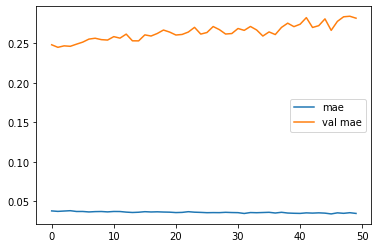

In [ ]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 4ms/step
1212.5225 4.6045594 1688.4948178777452


,actual,prediction
0,26000,26096.255859
1,26000,26193.513672
2,25900,26070.363281
3,25950,26182.890625
4,26000,26195.609375
...,...,...
229,24400,25440.207031
230,25000,25495.607422
231,25650,25525.781250
232,28850,25167.775391


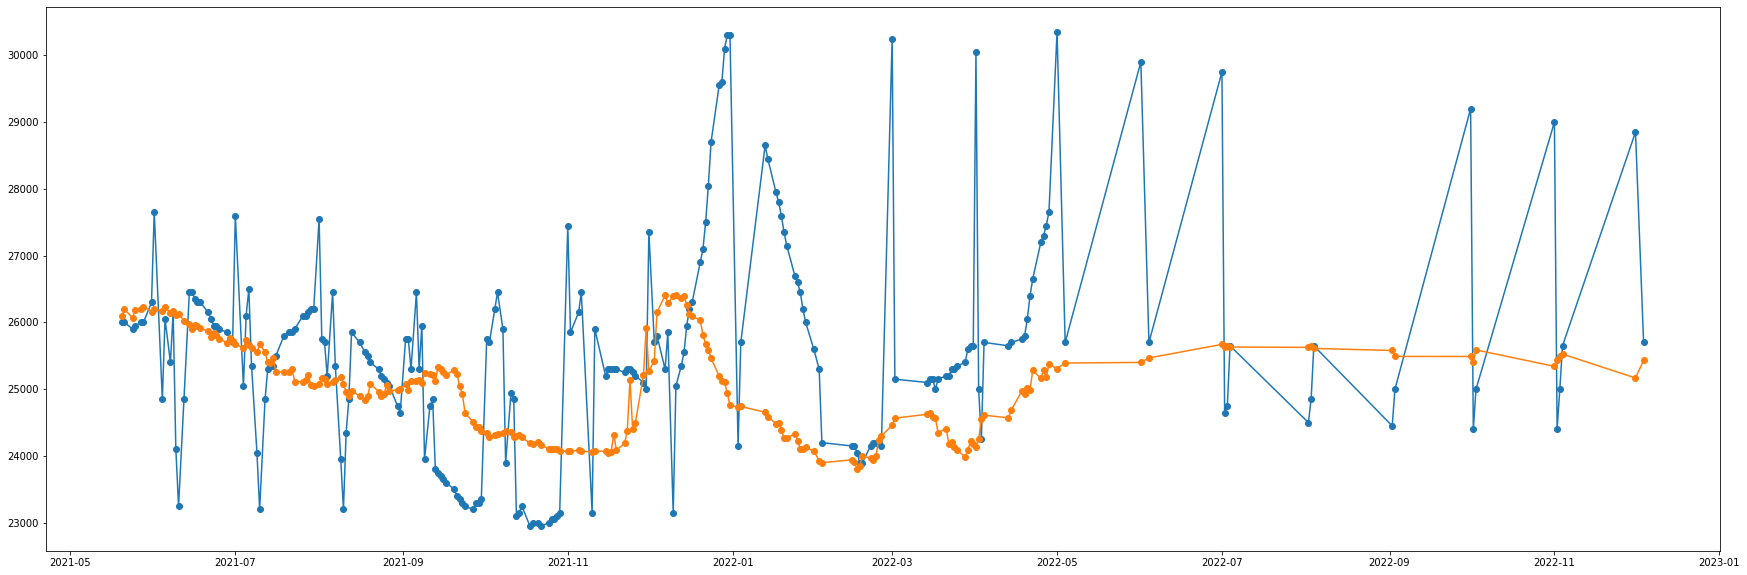

In [ ]:
prediction2_a2 = forecast_predict(model2_a, test_telur_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_telur2_a2 = pd.DataFrame()
data_new_telur2_a2['actual'] = x_test
data_new_telur2_a2['prediction'] = data_result2_a2
data_new_telur2_a2.to_csv('telur_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_telur2_a2.actual, '-o')
plt.plot(y_test,data_new_telur2_a2.prediction, '-o')
data_new_telur2_a2